In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fourier-decomposition-method/fdm.py
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/586w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/S084-1W.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/342mw1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/r229w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/382w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/192w.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/s083w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/573w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/387-02w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/s425w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/575w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/454-1W.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/719w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/32w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/517w1.eea
/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ/103w.eea

There are two EEG data archives for two groups of subjects. The subjects were adolescents who had been screened by psychiatrist and devided into two groups: healthy (n = 39) and with symptoms of schizophrenia (n = 45).

Each file contains an EEG record for one subject. Each TXT file contains a column with EEG samples from 16 EEG channels (electrode positions). Each number in the column is an EEG amplitude (mkV) at distinct sample. First 7680 samples represent 1st channel, then 7680 - 2nd channel, ets. The sampling rate is 128 Hz, thus 7680 samples refer to 1 minute of EEG record.



In [2]:
!pip install kymatio
!pip install livelossplot
!pip install pyEDFlib
!pip install mne
!pip install pywt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for configparser from https://files.pythonhosted.org/packages/81/a3/0e5ed11da4b7770c15f6f319abf053f46b5a06c7d4273c48469b7899bd89/configparser-6.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyEDFlib from https://files.pythonhosted.org/packages/d1/bc/ae0bb62a8f68c58b7c5ff1ea4a7ad1fd6649fcac06b5eba646e0aae9bf9d/pyEDFlib-0.1.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.9 MB/s eta 0:00:00:00:010:01
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from kymatio.keras import Scattering2D
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import mne
import glob
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import math
from scipy.signal import unit_impulse as imp
from scipy.fft import fft

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
sample = 7680
sf = 128 #Hz
sec = 2
num_channels = 16
phases = [math.pi/4,math.pi/8,math.pi/16,math.pi/32]

In [5]:
def read():
    path = '/kaggle/input/mhrc-dataset-data/'
    folders = ['SCZ-Dataset2-Normal/','SCZ-Dataset2-SCZ/']
    observations = []
    labels = []
    for idx,folder in enumerate(folders):
        files = glob.glob(path + folder + '*.eea')
        for filename in files:
            data = []
            labels.append(idx)
            with open(filename,'r') as file:
                contents = file.read()
                contents = contents.split(' \n')
                contents = [float(i) for i in contents[:-1]]
                for i in range(1,num_channels+1):
                    data.append(np.array(contents[(i-1)*sample : i*sample]))
                data = np.array(data)
                data.shape
            observations.append(data)
    observations = np.array(observations)
    labels = np.array(labels)
    return observations,labels
            

In [6]:
s,labels = read()

In [7]:
s.shape

(84, 16, 7680)

In [8]:
def divide(x):
    data = []
    jmp = sf*sec
    for curr in x:
        for i in range(0,sample,jmp):
            data.append(curr[:,i:i+jmp])
    return np.array(data)

In [30]:
container = divide(s)

In [31]:
labels = [0]*(int(60/sec)*39*2) + [1]*(45*int(60/sec)*2)
labels = np.array(labels)

In [36]:
container.shape,labels.shape

((5040, 16, 256), (5040,))

In [33]:
def gaussian_augmentation(samples):
    new_data = []
    for data in samples :
        new_data.append(data + np.random.normal(0,0.3,sec*sf))
    return np.array(new_data)

In [34]:
def phase_shift(samples,alpha):
    shifted = []
    for val in alpha:
        curr = []
        for data in samples:
            transformed = hilbert(data)
            temp = data*math.cos(val) + transformed*math.sin(val)
            curr.append(np.array(temp.real))
        shifted.append(curr)
    return np.array(shifted)

In [35]:
def augment_data(container):
    ret = []
    for sample in container:
        curr = gaussian_augmentation(sample)
        ret.append(curr)
        ret.append(sample)
    return np.array(ret)
container =  augment_data(container)

In [15]:
# container = temp.reshape(temp.shape[0]*temp.shape[1],temp.shape[2],temp.shape[3])

In [37]:
import sys
sys.path.insert(1,'/kaggle/input/fourier-decomposition-method')
from fdm import fdm

([<matplotlib.lines.Line2D at 0x7c7ad58f69b0>], 0)

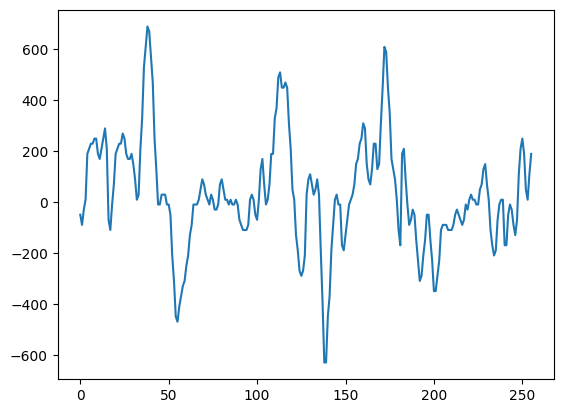

In [38]:
plt.plot(container[123,0]), labels[123]

In [39]:
data = []
for i in range(container.shape[0]):
    gamma,beta,alpha,theta,delta = [],[],[],[],[]
    for j in range(num_channels):
        curr = fdm(container[i,j,:].reshape(sf*sec,1), fs = sf , fc = np.array([4,8,12,35]), data_type='columns',plot_subbands= False)
        gamma.append(curr[:,0])
        beta.append(curr[:,1])
        alpha.append(curr[:,2])
        theta.append(curr[:,3])
        delta.append(curr[:,4])
    data.append(np.array([gamma,beta,alpha,theta,delta]))
data = np.array(data)

In [40]:
labels.shape

(5040,)

In [41]:
x_train,x_test,y_train,y_test = train_test_split(np.array(data),np.array(labels),test_size=0.2,random_state=42)
y_train = y_train.astype('double')
y_test = y_test.astype('double')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
# x_train, x_test = x_train / 255., x_test / 255.

x_train shape: (4032, 5, 16, 256) - y_train shape: (4032,)
x_test shape: (1008, 5, 16, 256) - y_test shape: (1008,)


In [42]:
from keras import layers , models
import keras    
from keras import regularizers
def DenseNet(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4),activity_regularizer=regularizers.L2(1e-5))(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        #Creates a sequence of numbers that begins at start and extends by increments of delta up to but not including limit.
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [43]:
def build_model(head_size=256,num_heads=4,ff_dim=4,num_transformer_blocks=4,mlp_units=[128],mlp_dropout=0.4,dropout=0.25):
    inputs = layers.Input(shape=(5,num_channels,sf*sec))
    
    # encoded_patches = PatchEncoder(25, 128)(patches)
    x = None
    y1 = Scattering2D(J=2, L=4)(inputs[:,0,:,:])
    y1 = PatchEncoder(y1.shape[1], 128)(tf.reshape(y1,[-1,y1.shape[1],y1.shape[2]*y1.shape[3]]))
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(y1, head_size, num_heads, ff_dim, dropout)
    representation1 = layers.LayerNormalization(epsilon=1e-6)(x)
    representation1 = layers.Flatten()(representation1)
    features1 = DenseNet(representation1, hidden_units=[1024,128], dropout_rate=0.5)

    y2 = Scattering2D(J=2, L=4)(inputs[:,1,:,:])
    y2 = PatchEncoder(y2.shape[1], 128)(tf.reshape(y2,[-1,y2.shape[1],y2.shape[2]*y2.shape[3]]))
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(y2, head_size, num_heads, ff_dim, dropout)
    representation2 = layers.LayerNormalization(epsilon=1e-6)(x)
    representation2 = layers.Flatten()(representation2)
    features2 = DenseNet(representation2, hidden_units=[1024,128], dropout_rate=0.5)

    y3 = Scattering2D(J=2, L=4)(inputs[:,2,:,:])
    y3 = PatchEncoder(y3.shape[1], 128)(tf.reshape(y3,[-1,y3.shape[1],y3.shape[2]*y3.shape[3]]))
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(y3, head_size, num_heads, ff_dim, dropout)
    representation3 = layers.LayerNormalization(epsilon=1e-6)(x)
    representation3 = layers.Flatten()(representation3)
    features3 = DenseNet(representation3, hidden_units=[1024,128], dropout_rate=0.5)

    y4 = Scattering2D(J=2, L=4)(inputs[:,3,:,:])
    y4 = PatchEncoder(y4.shape[1], 128)(tf.reshape(y4,[-1,y4.shape[1],y4.shape[2]*y4.shape[3]]))
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(y4, head_size, num_heads, ff_dim, dropout)
    representation4 = layers.LayerNormalization(epsilon=1e-6)(x)
    representation4 = layers.Flatten()(representation4)
    features4 = DenseNet(representation4, hidden_units=[1024,128], dropout_rate=0.5)

    y5 = Scattering2D(J=2, L=4)(inputs[:,4,:,:])
    y5 = PatchEncoder(y5.shape[1], 128)(tf.reshape(y5,[-1,y5.shape[1],y5.shape[2]*y5.shape[3]]))
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(y5, head_size, num_heads, ff_dim, dropout)
    representation5 = layers.LayerNormalization(epsilon=1e-6)(x)
    representation5 = layers.Flatten()(representation5)
    features5 = DenseNet(representation5, hidden_units=[1024,128], dropout_rate=0.5)

    features = tf.concat([features1,features2,features3,features4,features5],axis=1)
    # features5 = DenseNet(features, hidden_units=[128,64], dropout_rate=0)
    logits = layers.Dense(1, activation = 'sigmoid')(features)
   
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [44]:
model = build_model(
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 16, 256)]         0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 16, 256)              0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 16, 256)              0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                              

In [45]:
!pip install livelossplot

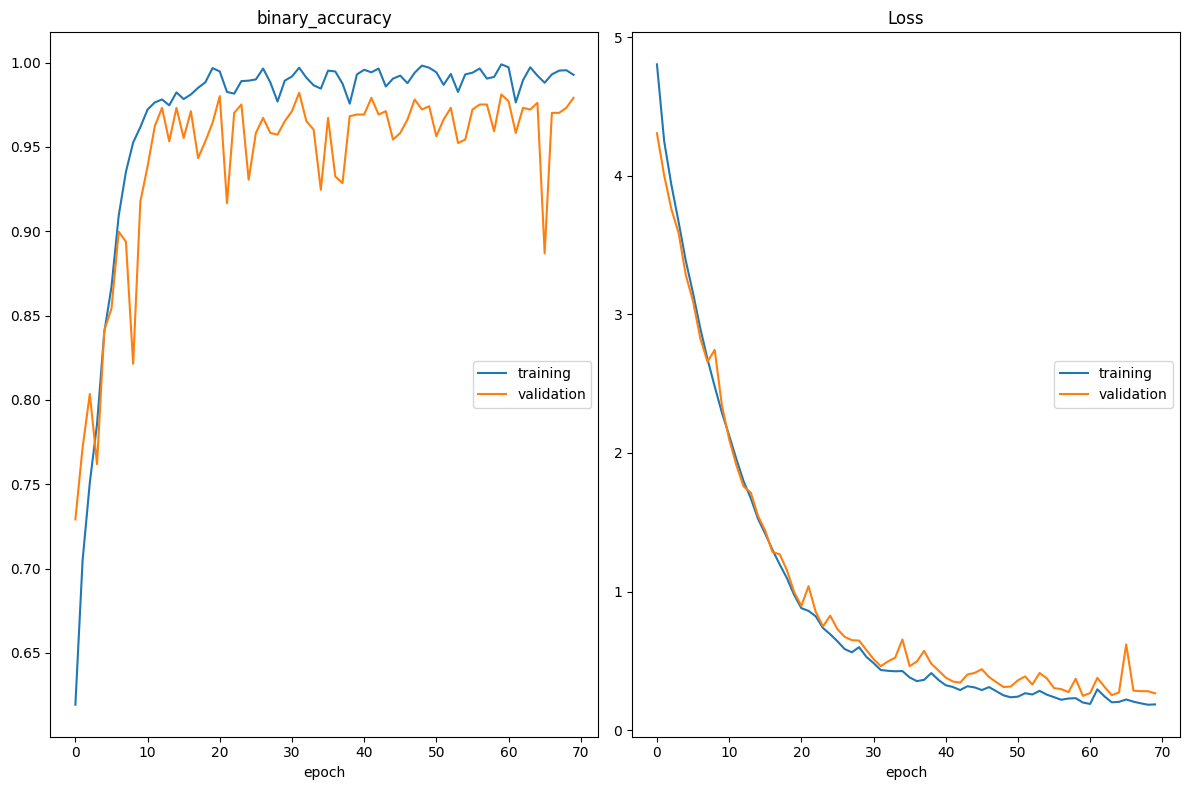

binary_accuracy
	training         	 (min:    0.619, max:    0.999, cur:    0.993)
	validation       	 (min:    0.729, max:    0.982, cur:    0.979)
Loss
	training         	 (min:    0.184, max:    4.804, cur:    0.186)
	validation       	 (min:    0.248, max:    4.307, cur:    0.266)
504/504 [==============================] - 23s 46ms/step - loss: 0.1861 - binary_accuracy: 0.9928 - val_loss: 0.2661 - val_binary_accuracy: 0.9792


In [46]:
from livelossplot import PlotLossesKeras
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),PlotLossesKeras()]

history = model.fit(
    x_train,
    y_train,
    epochs=150,
    batch_size=8,
    callbacks=callbacks,
    validation_data=(x_test,y_test)
)

Text(0.5, 1.0, 'Loss Plot')

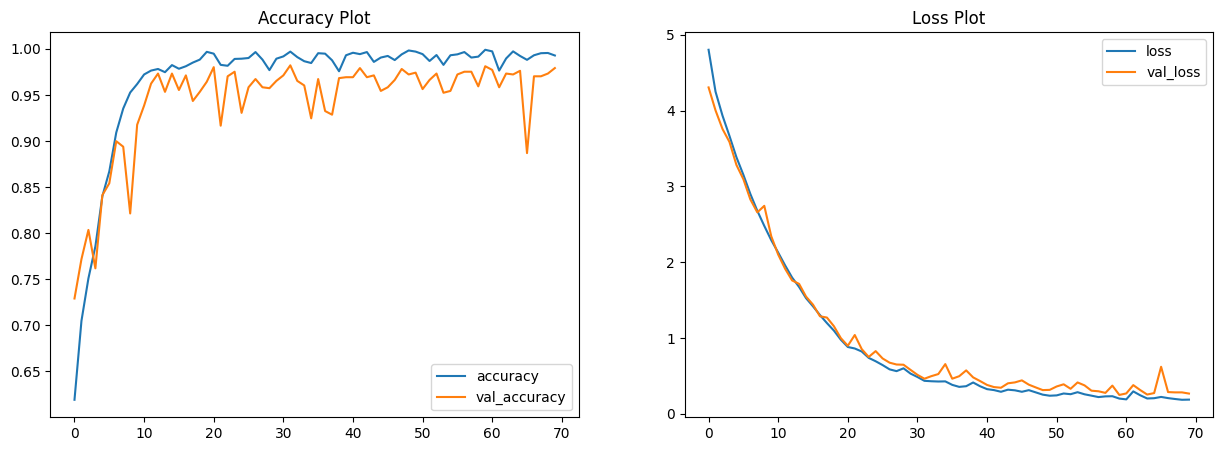

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Plot')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss Plot')

32/32 [==============================] - 8s 31ms/step


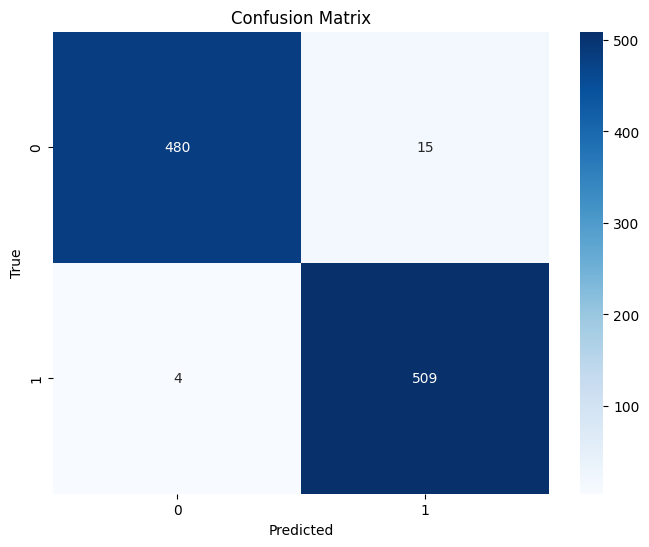

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, model.predict(x_test).round())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [49]:
precision = (cm[1][1]/(cm[1][1]+cm[0][1]))*100
print(f'Precision = {precision}%')

recall = (cm[1][1]/(cm[1][1]+cm[1][0]))*100
print(f'Recall = {recall}%')

f1_score = (2*precision*recall)/(precision+recall)
print(f'F1 Score = {f1_score}%')


Precision = 97.13740458015268%
Recall = 99.22027290448344%
F1 Score = 98.16779170684669%


In [ ]:
import tsgm

In [ ]:
def augment(container):
    aug_model = tsgm.models.augmentations.GaussianNoise(0.2)
    for sample in container:
        for channel in sample:
            samples = aug_model.generate(X=channel, n_samples=10)
            print(samples.shape)
            break
augment(container[0])